## Macromolecular model

This case study follows from the model presented in:

*Omta et al. 2017. Extracting physiological traits from batch and chemostate culture data. L&O*

The equations are below.

\begin{equation} \frac{dC}{dt} = (C_{syn} - E)P \end{equation}
\begin{equation} \frac{dP}{dt} = P_{syn}P \end{equation}
\begin{equation} \frac{dr}{dt} = \frac{1}{\tau}(r_0 - r) \end{equation}
\begin{equation} \frac{dN}{dt} = -\frac{dP}{dt} \end{equation}

\begin{equation} P_{syn} = \mu\left(\frac{N}{N+K}\right) \end{equation}
\begin{equation} r_0 = b\frac{P}{C} \end{equation}
\begin{equation} r_{cell} = \frac{C}{P} \end{equation}
\begin{equation} E = \frac{1}{2}m_{ex}\left(1+\tanh\left(r_{cell} - r_{ex}\right)\right) \end{equation}

In [1]:
%matplotlib notebook
import numpy as np
import pystan

In [2]:
mod_code = '''functions {
  real[] macro(real   t,           // time
               real[] x,           // state x[1]:CH  x[2]:PR, x[3]:Chl , x[4]:N
               real[] theta,
               real[] x_r,
               int[]  x_i) {       // parameters

    real CNpro = theta[1]; 
    real KN    = theta[2];    
    real mu    = theta[3]; 
    real CHsyn = theta[4]; 
    real m_ex  = theta[5];  
    real R_ex  = theta[6];  
    real tau   = theta[7];
    real b     = theta[8];

    real PRsynth = theta[3]*x[4]/(theta[2]+x[4]);
    real r0      = theta[8]*(x[2]/x[1]);
    real Chl     = x[3]*x[2];
    real Rcell   = x[1]/x[2];
    real excr    = (1/2)*theta[5]*(1+tanh(Rcell - theta[6]));
    
    real dCH    = x[2]*(theta[4] - excr);
    real dr     = (1/theta[7])*(r0-x[3]);
    real dPR    = x[2]*PRsynth;
    real dN     = -dPR/(1+exp(-10000*x[4])); 

    return {dCH,dPR,dr,dN};
  }
}
data {
  int<lower = 0> n;           // num obs
  real t_obs[n];              // obs times
  real<lower = 0> y[n,4];     // observed variable at measurement times
}
parameters {
  real<lower = 0> theta[8];   // parameters
  real<lower = 0> x0[4];      // initial population
  real<lower = 1E-15> sigma[4]; // obs error
}
transformed parameters {
  real x[n,4] = integrate_ode_rk45(macro, x0, -1, t_obs, theta, rep_array(0.0,0), rep_array(0,0), 1e-6, 1e-5, 1e3) ;
  for(i in 1:n){
    x[i,3] = x[i,3]*x[i,2]*1E6;
  }
}
model {
  x0[1]    ~ normal(0.1,1);
  x0[2]    ~ normal(0.1,1);
  x0[3]    ~ normal(10,10);
  x0[4]    ~ normal(0.1,1);  
  theta[1] ~ normal(6.6,10); //prior on CHpro
  theta[2] ~ normal(0.002,3); //prior on KN
  theta[3] ~ normal(0.3,1);
  theta[4] ~ normal(5,10);
  theta[5] ~ normal(10,10);
  theta[6] ~ normal(13,10);
  theta[7] ~ normal(10,10); 
  theta[8] ~ normal(0.05,5); 
  
  for(i in 1:4){
    y[1:n,i] ~ normal(x[1:n,i], sigma[i]);
  }
}
'''

In [3]:
import pandas # heavy CSV file usage ahead

dat = pandas.read_csv('data/macromolecules.csv')
dat_flynn = pandas.read_csv('data/flynn_macromolecules.csv')

dat['N'] *= 0.001  # PR
dat['chl'] *= 1000 # chl
dat['C'] *= 0.001  # C
dat = dat.merge(dat_flynn.loc[:,('t','ammonium')], on='t') #add environmental nitrogen to the data
dat['ammonium'] *= 0.08325909 # N

# rename for consistency
dat = dat.rename(columns={'N':'PR','ammonium':'N','C':'CH'})

dat.head()

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,t,PR,chl,CH,N
0,5.0,0.018571,15.6689,0.124167,0.107238
1,5.5,0.019286,19.0265,0.178333,0.104906
2,6.0,0.045714,20.1457,0.131667,0.104657
3,6.5,0.025714,45.8875,0.172500,0.102076
4,7.0,0.025714,45.8875,0.170000,0.102076


In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12,9))
for ax,key in zip(axs.flat, dat.keys()[1:]):
    ax.scatter(dat['t'], dat[key])
    ax.set(ylabel=key)

In [5]:
data = {'n':len(dat), 't_obs':dat['t'], 'y':dat.loc[:,('CH','PR','chl','N')]}

In [6]:
mod = pystan.StanModel(model_code=mod_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_58183e16624b48cb40accb8bc1721453 NOW.


In [7]:
mcmc = mod.sampling(data=data, iter=2000, chains=4)
print(mcmc)

Inference for Stan model: anon_model_58183e16624b48cb40accb8bc1721453.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
theta[1]  10.82    0.11   7.11    0.58    5.15   10.03   15.23  27.07   3833    1.0
theta[2]   0.02  2.7e-4   0.01  5.8e-3    0.01    0.02    0.03   0.05   1739    1.0
theta[3]   0.48  2.2e-3   0.08    0.36    0.42    0.47    0.53   0.68   1519    1.0
theta[4]   1.29  1.3e-3   0.07    1.15    1.24    1.29    1.33   1.43   2514    1.0
theta[5]  13.06    0.13   7.78    1.14    7.03   12.32   17.94   30.4   3403    1.0
theta[6]  14.79    0.15   8.53    1.02    8.42   14.03   20.35  33.69   3080    1.0
theta[7]  11.41    0.03   1.74    8.54   10.21   11.21   12.42  15.21   2640    1.0
theta[8]   0.05  5.4e-5 2.5e-3    0.04    0.05    0.05    0.05   0.05   2139    1.0
x0[1]      0.32  1.3e-3   0.06    0.21    0.29    0.33 

In [8]:
theta_names = ('CNpro','KN','mu','CHsyn','m_ex','R_ex','tau','b')
state_names = ('CH','PR','chl','N')
#name_mapping = {'CH':'x[1]', 'PR':'x[2]', 'chl':'x[3]', 'N':'x[4]'}

(4000, 8)


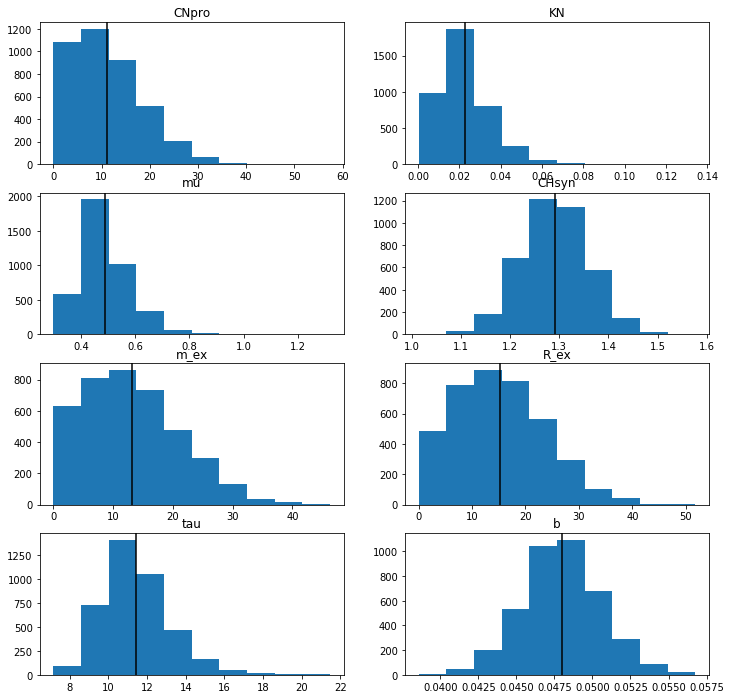

In [9]:
print(mcmc['theta'].shape)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
for iax,ax in enumerate(axs.flat):
    ax.hist(mcmc['theta'][:,iax])
    ax.axvline(np.mean(mcmc['theta'][:,iax]), color='black')
    ax.set_title(theta_names[iax])

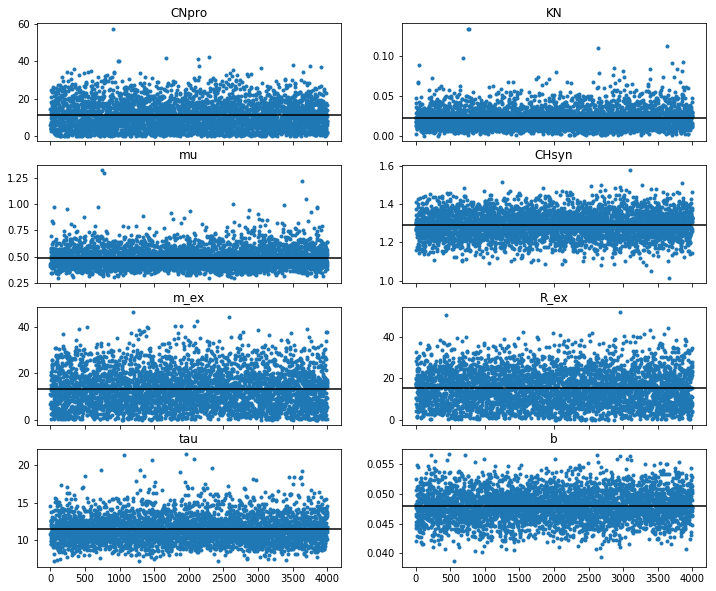

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(12,10))
for iax,ax in enumerate(axs.flat):
    ax.plot(mcmc['theta'][:,iax], marker='.', linestyle='none')
    ax.axhline(np.mean(mcmc['theta'][:,iax]), color='black')
    ax.set_title(theta_names[iax])

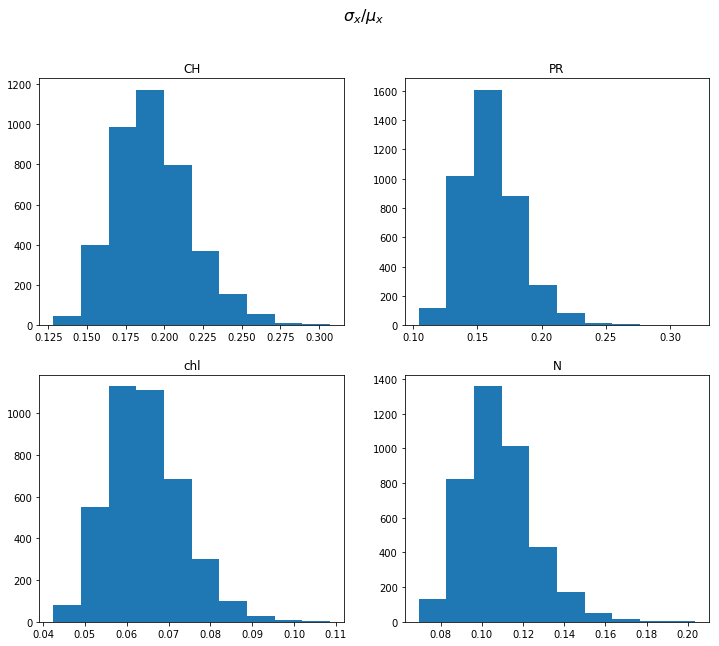

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for iax,ax in enumerate(axs.flat):
    ax.hist(mcmc['sigma'][:,iax]/np.mean(mcmc['x'][:,:,iax]))
    ax.set_title(state_names[iax])
fig.suptitle('$\sigma_x/\mu_x$', size=16)
None

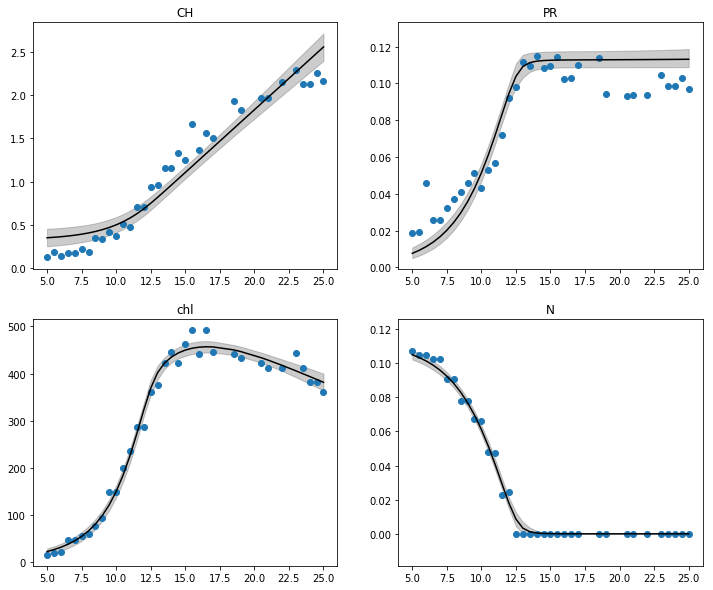

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
for iax,ax in enumerate(axs.flat):
    name = state_names[iax]
    ax.scatter(dat['t'], dat[name])

    ax.plot(data['t_obs'], np.mean(mcmc['x'][:,:,iax], axis=0), color='black')
    perc = np.percentile(mcmc['x'][:,:,iax], q=(2.5,97.5), axis=0)
    ax.fill_between(data['t_obs'], perc[0,:], perc[1,:], color='black', alpha=0.2, zorder=0)
    
    ax.set_title(name)

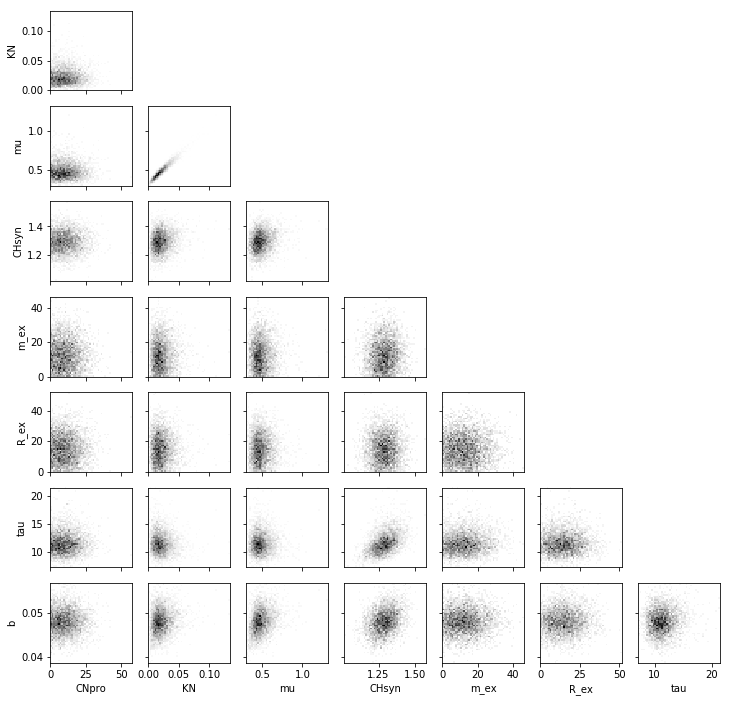

In [13]:
num_params = len(theta_names)
cmap = plt.get_cmap('gray_r')

fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = theta_names[icol]
        yname = theta_names[irow]
        ax.hist2d(mcmc['theta'][:,icol],mcmc['theta'][:,irow],bins=50,cmap=cmap)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)